total_infection_rate 0.015834 max_infections_rate 0.0053778 total_death_rate 0.0004757 t_stop 29.4508 t_peak 9.0912
total_infection_rate 0.0142418 max_infections_rate 0.0051581 total_death_rate 0.0004178 t_stop 28.0907 t_peak 8.0604
total_infection_rate 0.0125609 max_infections_rate 0.0048819 total_death_rate 0.000363 t_stop 26.421 t_peak 7.1776
total_infection_rate 0.0117087 max_infections_rate 0.0047658 total_death_rate 0.0003511 t_stop 25.3086 t_peak 6.7545
total_infection_rate 0.0103244 max_infections_rate 0.0045453 total_death_rate 0.000307 t_stop 23.4908 t_peak 5.6435
total_infection_rate 0.0093849 max_infections_rate 0.0043684 total_death_rate 0.0002735 t_stop 22.5131 t_peak 5.2929
total_infection_rate 0.0085477 max_infections_rate 0.0042245 total_death_rate 0.0002629 t_stop 21.3303 t_peak 4.71
total_infection_rate 0.00784 max_infections_rate 0.0041115 total_death_rate 0.0002343 t_stop 20.2713 t_peak 4.3238
total_infection_rate 0.0072666 max_infections_rate 0.0039776 total_death

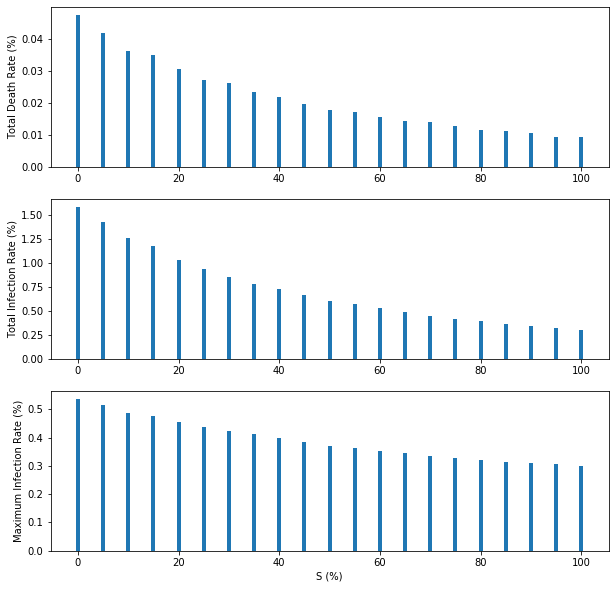

In [1]:
import random
import math
import numpy
from enum import Enum
import matplotlib.pyplot as plt

class Direction(Enum):
    IMMOBILE = 0
    N = 1
    NE = 2
    E = 3
    SE = 4
    S = 5
    SW = 6
    W = 7
    NW = 8
    
def move(x, y, direction, N):
    if direction is Direction.N and x>0:
        return (x-1, y)
    if direction is Direction.NE and y+1<N and x>0:
        return (x-1, y+1)
    if direction is Direction.E and y+1<N:
        return (x, y+1)
    if direction is Direction.SE and x+1<N and y+1<N:
        return (x+1, y+1)
    if direction is Direction.S and x+1<N:
        return (x+1, y)
    if direction is Direction.SW and y>0 and x+1<N:
        return(x+1, y-1)
    if direction is Direction.W and y>0:
        return (x, y-1)
    if direction is Direction.NW and x>0 and y>0:
        return (x-1, y-1)
    
    raise Exception('Invalid move!')

def changeDir(direction):
    newDirection = Direction(random.choice(list(range(1, direction.value)) + list(range(direction.value+1, 9))))
    assert newDirection is not direction
    return newDirection
    
def run(grid, init_infections, K, P_m, P_d):
    N = len(grid)

    t_stop = 0
    total_deaths = 0
    current_infections = max_infections = total_infections = init_infections
    t_peak = 0
    
    while current_infections > 0:
        t_stop += 1
        modified = set([]) # keep track of cells that have already moved
        
        # move
        for x in range(N):
            for y in range(N):
                if grid[x][y] == (-1, -1, -1, -1, 0):
                    # unoccupied, NOP
                    continue
                
                if (x, y) in modified:
                    # already changed
                    continue
                
                (ci, cd, ni, nd, immune) = grid[x][y]
                
                if cd is Direction.IMMOBILE or random.uniform(0, 1) > P_m:
                    grid[x][y] = (ci, cd, max(ni, ci-1, 0), nd, immune)
                else:
                    try:
                        (newX, newY) = move(x, y, cd, N)
                        if grid[newX][newY] == (-1, -1, -1, -1, 0):
                            # move to unoccupied cell
                            grid[newX][newY] = (ci, cd, max(ni, ci-1, 0), cd, immune)
                            grid[x][y] = (-1, -1, -1, -1, 0)
                            modified.add((newX, newY))
    
                        else: # collision
                            (other_ci, other_cd, other_ni, other_nd, other_immune) = grid[newX][newY]
                            
                            if other_ci:
                                # collide with an infected person
                                if ci:
                                    # and currently infected
                                    grid[x][y] = (ci, cd, ci-1, changeDir(cd), immune)
                                else:
                                    # and currently healthy
                                    grid[x][y] = (ci, cd, randExp(K), changeDir(cd), -1)
                                    total_infections += 1
                                
                            else:
                                # collide with a health person
                                if ci:
                                    # and currently infected
                                    grid[x][y] = (ci, cd, ci-1, changeDir(cd), immune)
                                    if not other_immune:
                                        grid[newX][newY] = (other_ci, other_cd, randExp(K), other_nd, -1)
                                        total_infections += 1
                                else:
                                    # and currently healthy
                                    grid[x][y] = (ci, cd, max(ni,ci-1), changeDir(cd), immune)
                    except:
                        # reach the edge/corner of the grid
                        grid[x][y] = (ci, cd, max(ni,ci-1, 0), changeDir(cd), immune)
        
        # infect, immune, or die
        for x in range(N):
            for y in range(N):
                if grid[x][y] == (-1, -1, -1, -1, 0):
                    continue
                (ci, cd, ni, nd, immune) = grid[x][y]
                if ni == 0 and immune < 0:
                    if random.uniform(0, 1) > P_d: # immune
                        grid[x][y] = (ni, nd, ni, nd, 1)
                    else: # die
                        grid[x][y] = (-1, -1, -1, -1, 0)
                        total_deaths += 1
                else:
                    grid[x][y] = (ni, nd, max(ni-1, 0), nd, immune)
        
        current_infections = 0
        for x in range(N):
            for y in range(N):
                current_infections += 1 if grid[x][y][0] > 0 else 0
        
        if current_infections > max_infections:
            max_infections = current_infections
            t_peak = t_stop
                
    return (total_infections, max_infections, total_deaths, t_stop, t_peak)

def randExp(beta):
    return numpy.random.exponential(beta, 1)[0]

def plot(tot_death_rates, tot_inf_rates, max_inf_rates):
    fig = plt.figure(figsize=(10,10))
    fig.add_subplot(311)
    plt.bar(list(range(0,101,5)), tot_death_rates)
    plt.ylabel('Total Death Rate (%)')
    
    fig.add_subplot(312)
    plt.bar(list(range(0,101,5)), tot_inf_rates)
    plt.ylabel('Total Infection Rate (%)')
    
    fig.add_subplot(313)
    plt.bar(list(range(0,101,5)), max_inf_rates)
    plt.xlabel('S (%)')
    plt.ylabel('Maximum Infection Rate (%)')
                        
N, M, X, P_m, P_d, K, R = 100, 1000, 0.003, 0.8, 0.03, 6, 10000
tot_death_rates = []
tot_inf_rates = []
max_inf_rates = []

for S in range(0, 101, 5):
    # generate the initial state
    init_infections = math.ceil(M*X)
    total_deaths, total_infections, max_infections, t_stop, t_peak = 0, init_infections, init_infections, 0, 0
    
    for r in range(R):
        # grid = [,[,(currentRemainingInfectionPeriod, currentDirection, nextRemainingInfectionPeriod, nextDirection, immune)]]
        grid = [[(-1, -1, -1, -1, 0) for x in range(N)] for y in range(N)]
        population = random.sample([(x, y) for x in range(N) for y in range(N)], M)
        infectedPopulation = random.sample(population, init_infections)
        mobilePopulation = random.sample(population, math.ceil(M*(1-S*1.0/100)))
        
        # immune -1 = currently infected, 0 = never infected, 1 = immune
        for person in population:
            (x, y) = person
            immune = -1 if person in infectedPopulation else 0
            remainingInfectionPeriod = randExp(K) if immune == -1 else 0
            direction =  Direction(random.randint(1, 8)) if person in mobilePopulation else Direction.IMMOBILE
            grid[x][y] = (remainingInfectionPeriod, direction, max(remainingInfectionPeriod-1, 0), direction, immune)
        
        (ti, mi, d, t, tp) = run(grid, init_infections, K, P_m, P_d)
        total_infections += ti
        max_infections += mi
        total_deaths += d
        t_stop += t
        t_peak += tp
    
    tot_death_rates.append(total_deaths*100.0/(R*M))
    tot_inf_rates.append(total_infections*100.0/(R*M))
    max_inf_rates.append(max_infections*100.0/(R*M))
    
    print('total_infection_rate', total_infections*1.0/(R*M), 'max_infections_rate', max_infections*1.0/(R*M), 'total_death_rate', total_deaths*1.0/(R*M), 't_stop', t_stop*1.0/R, 't_peak', t_peak*1.0/R)

plot(tot_death_rates, tot_inf_rates, max_inf_rates)

